In [2]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pandas as pd
from statsmodels.tsa.ar_model import AutoReg


## ACF and PACF of ARMA processes

Today we shall first look at the theoretical ACF and PACF functions of ARMA processes. The key observation is this: (a) For MA($q$), the ACF becomes zero for $h > q$. (b) For AR($p$), the PACF becomes zero for $h > p$. (c) For ARMA(p, q) with both $p, q \geq 1$, neither the ACF nor the PACF becomes zero after a finite lag. In this case, determining $p$ and $q$ by looking at the ACF and PACF alone is difficult. 

In the code below, we are using the statsmodels functions arma_acf and arma_pacf below to compute the ACF and PACF. Different ARMA  processes are obtained by changing the ma_coeffs and ar_coeffs in the code below. 

In [3]:
from statsmodels.tsa.arima_process import ArmaProcess, arma_acf, arma_pacf

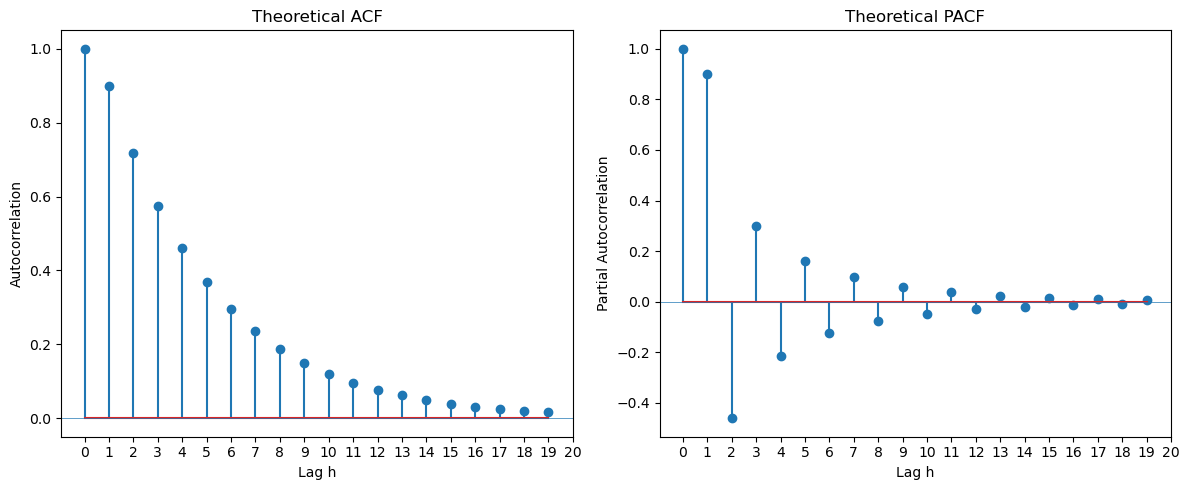

In [148]:
#MA(1)
#th = 0.8
#ma_coeffs = [1]
#ma_coeffs = [1, 0, 0, 0, th]
ma_coeffs = [1, th]
#ma_coeffs = [1, 0.8, 0.6]
ph = 0.8
#ph = -0.8
ar_coeffs = [1]
ar_coeffs = [1, -ph] #these are the coefficients of the AR polynomial (note the sign changes)
#ar_coeffs = [1, -0.5, 0.25]
#ar_coeffs = [1, 0, 0, 0, -ph]
#th2 = 0.8
#ma_coeffs = [1, th, th2]
L = 20
corrs = arma_acf(ar = ar_coeffs, ma = ma_coeffs, lags = L)
par_corrs = arma_pacf(ar = ar_coeffs, ma = ma_coeffs, lags = L)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 5))
ax1.stem(range(L), corrs)
ax1.set(title = 'Theoretical ACF', xlabel = 'Lag h', ylabel = 'Autocorrelation')
ax1.axhline(0, lw = 0.5)
ax1.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]) 

ax2.stem(range(L), par_corrs)
ax2.set(title = 'Theoretical PACF', xlabel = 'Lag h', ylabel = 'Partial Autocorrelation')
ax2.axhline(0, lw = 0.5)
ax2.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]) 
plt.tight_layout()
plt.show()

## ARMA($p$, $q$) models for the GNP dataset

Let us consider the GNP dataset from FRED.

  observation_date      GNP
0       1947-01-01  244.142
1       1947-04-01  247.063
2       1947-07-01  250.716
3       1947-10-01  260.981
4       1948-01-01  267.133


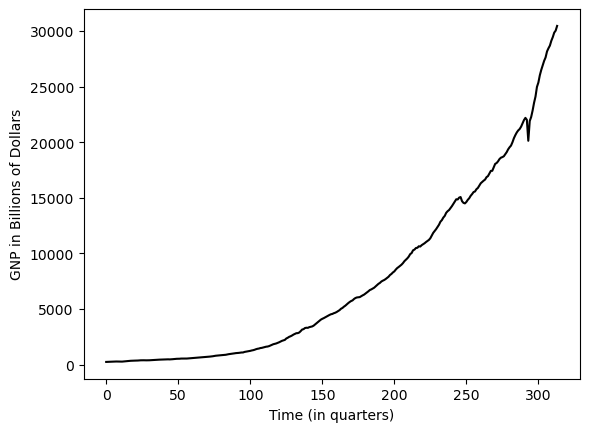

In [149]:
gnp = pd.read_csv("GNP_17Nov2025.csv")
#this is quarterly data
print(gnp.head())

y = gnp['GNP'].to_numpy()
plt.plot(y, color = 'black')
plt.xlabel('Time (in quarters)')
plt.ylabel('GNP in Billions of Dollars')
plt.show()

Instead of working with raw data, we work with logarithms. 

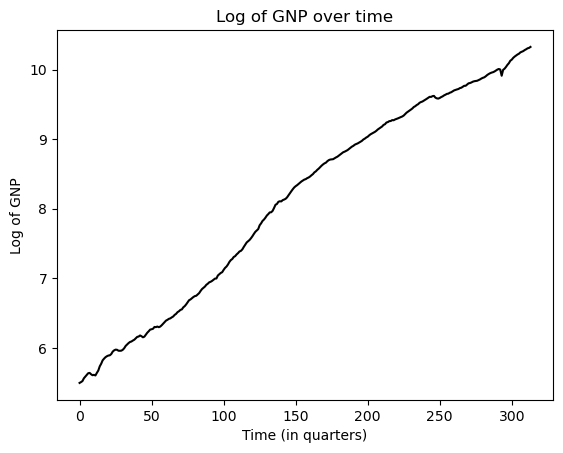

In [150]:
ylog = np.log(y)
plt.plot(ylog, color = 'black')
plt.title('Log of GNP over time')
plt.xlabel('Time (in quarters)')
plt.ylabel('Log of GNP')
plt.show()

It does not make sense to fit stationary ARMA($p$, $q$) models directly to the above dataset. So we take differences. 

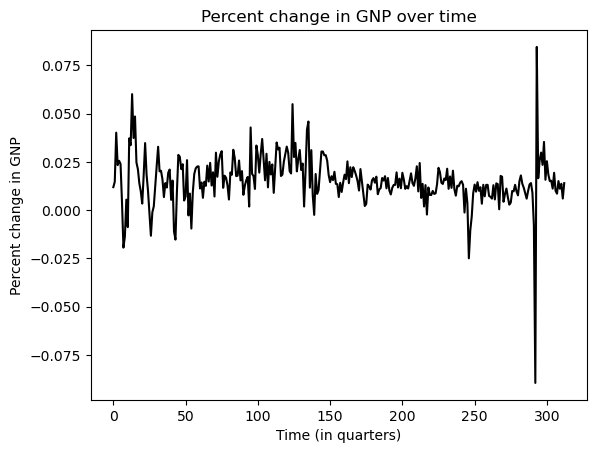

In [151]:
#We difference the log-data:
ylogdiff = np.diff(ylog)
plt.plot(ylogdiff, color = 'black')
plt.title('Percent change in GNP over time')
plt.xlabel('Time (in quarters)')
plt.ylabel('Percent change in GNP')
plt.show()

## ARMA($p$, $q$) model fitting, AIC and BIC

We now fit an ARMA($p$, $q$) model to this differenced dataset. Let us see how to fit an ARMA(1, 1) model. 

In [152]:
arma11 = ARIMA(ylogdiff, order = (1, 0, 1)).fit()
print(arma11.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  313
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 932.499
Date:                Tue, 18 Nov 2025   AIC                          -1856.999
Time:                        16:22:26   BIC                          -1842.014
Sample:                             0   HQIC                         -1851.010
                                - 313                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0154      0.001     10.429      0.000       0.013       0.018
ar.L1          0.6911      0.139      4.955      0.000       0.418       0.964
ma.L1         -0.4642      0.152     -3.054      0.0

The summary above gives maximized log-likelihood (called Log Likelihood) and also AIC and BIC. The maximized log-likelihood is the value of the log-likelihood at the MLEs. The AIC are BIC are given by:

AIC for a model = $(-2) \times$ (maximized log-likelihood) + 2 (number of parameters)

BIC for a model = $(-2) \times $(maximized log-likelihood) + ($\log n$) \times (number of parameters)
where $n$ denotes the sample size. 

In [153]:
print(arma11.llf) #maximized log-likelihood
print(arma11.aic, (-2)*arma11.llf + 2*4) #AIC (note the number of parameters here equals 4)
print(arma11.bic, (-2)*arma11.llf + np.log(len(ylogdiff))*4) #BIC

932.4992964756076
-1856.9985929512152 -1856.9985929512152
-1842.0137801890546 -1842.0137801890546


### Selecting the best ARMA($p$, $q$) model by automatic model selection

We will go over all ARMA($p$, $q$) models with $p \leq 5$ and $q \leq 5$ and find the best fitting ARMA($p$, $q$) model using AIC and BIC. In the code below, if parameter estimation does not work for some reason for some $p$ and $q$, then the value NaN is given for AIC and BIC for that model.

In [154]:
import warnings
warnings.filterwarnings("ignore") #this suppresses convergence warnings. 

dt = ylogdiff
pmax = 5
qmax = 5

aicmat = np.full((pmax + 1, qmax + 1), np.nan)
bicmat = np.full((pmax + 1, qmax + 1), np.nan)

for i in range(pmax + 1):
    for j in range(qmax + 1):
        try:
            model = ARIMA(dt, order=(i, 0, j)).fit()
            aicmat[i, j] = model.aic
            bicmat[i, j] = model.bic
        except Exception as e:
            # Some models may not converge; skip them
            print(f"ARIMA({i},0,{j}) failed: {e}")
            continue

aic_df = pd.DataFrame(aicmat, index=[f'AR({i})' for i in range(pmax+1)],
                               columns=[f'MA({j})' for j in range(qmax+1)])
bic_df = pd.DataFrame(bicmat, index=[f'AR({i})' for i in range(pmax+1)],
                               columns=[f'MA({j})' for j in range(qmax+1)])

# Best AR model (MA = 0)
best_ar_aic = np.nanargmin(aicmat[:, 0])
best_ar_bic = np.nanargmin(bicmat[:, 0])

# Best MA model (AR = 0)
best_ma_aic = np.nanargmin(aicmat[0, :])
best_ma_bic = np.nanargmin(bicmat[0, :])

# Best ARMA model overall
best_arma_aic = np.unravel_index(np.nanargmin(aicmat), aicmat.shape)
best_arma_bic = np.unravel_index(np.nanargmin(bicmat), bicmat.shape)

# Print results
print(f"Best AR model by AIC: AR({best_ar_aic})")
print(f"Best AR model by BIC: AR({best_ar_bic})")

print(f"Best MA model by AIC: MA({best_ma_aic})")
print(f"Best MA model by BIC: MA({best_ma_bic})")

print(f"Best ARMA model by AIC: ARMA{best_arma_aic}")
print(f"Best ARMA model by BIC: ARMA{best_arma_bic}")


Best AR model by AIC: AR(2)
Best AR model by BIC: AR(2)
Best MA model by AIC: MA(3)
Best MA model by BIC: MA(2)
Best ARMA model by AIC: ARMA(2, 0)
Best ARMA model by BIC: ARMA(2, 0)


It seems that no errors were thrown for any of the ARMA models. There are a lot of warnings though. Go back and remove the warnings suppression code. 

The best overall model here is AR(2). 

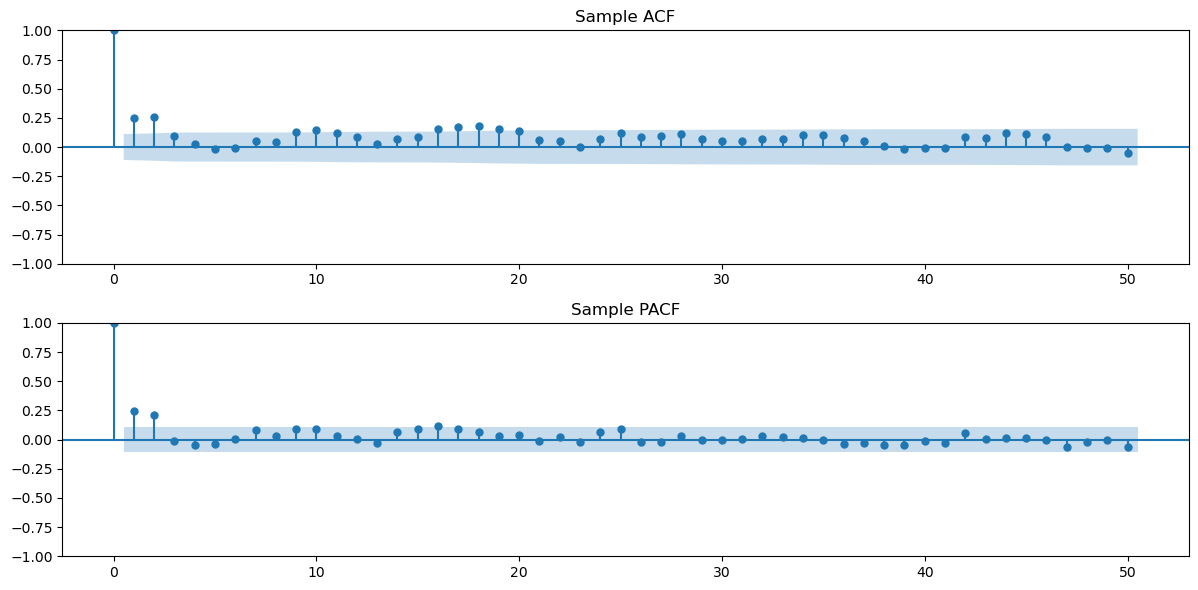

In [155]:
h_max = 50
fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (12, 6))
plot_acf(ylogdiff, lags = h_max, ax = axes[0])
axes[0].set_title("Sample ACF")
plot_pacf(ylogdiff, lags = h_max, ax = axes[1])
axes[1].set_title("Sample PACF")
plt.tight_layout()
plt.show()

AR(2) seems like a good model overall. 

In [158]:
ar2 = ARIMA(ylogdiff, order = (2, 0, 0)).fit()
print(ar2.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  313
Model:                 ARIMA(2, 0, 0)   Log Likelihood                 935.005
Date:                Tue, 18 Nov 2025   AIC                          -1862.010
Time:                        16:27:21   BIC                          -1847.025
Sample:                             0   HQIC                         -1856.022
                                - 313                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0154      0.001     10.725      0.000       0.013       0.018
ar.L1          0.1971      0.025      7.856      0.000       0.148       0.246
ar.L2          0.2077      0.066      3.140      0.0

Below we obtain predictions for this AR(2) model. These would be predictions for $\log(y_t) - \log(y_{t-1})$. We can convert them to predictions for $\log(y_t)$ as in the code below. 

In [159]:
n = len(y)
k = 100
fcast_diff_1 = ar2.get_prediction(start = n-1, end = n+k-2).predicted_mean #these are the forecasts for the differenced data
last_observed_ylog = ylog[-1]
fcast_1 = np.zeros(k)
fcast_1[0] = last_observed_ylog + fcast_diff_1[0]
for i in range(1, k):
    fcast_1[i] = fcast_1[i-1] + fcast_diff_1[i]


In [160]:
tme = range(1, n+1)
tme_future = range(n+1, n+k+1)

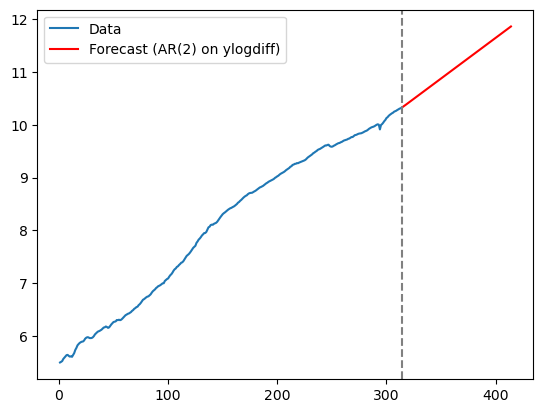

In [161]:
plt.plot(tme, ylog, label = 'Data')
plt.plot(tme_future, fcast_1, label = 'Forecast (AR(2) on ylogdiff)', color = 'red')
plt.axvline(x=n, color='gray', linestyle='--')
plt.legend()
plt.show()

## ARIMA Models

Instead of fitting AR(2) to the differences of the logs, we can fit ARIMA with $p = 2, d = 1, q = 0$ on logarithms. 

In [162]:
ar2_nodiff = ARIMA(ylog, order = (2, 1, 0)).fit()
print(ar2_nodiff.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  314
Model:                 ARIMA(2, 1, 0)   Log Likelihood                 909.630
Date:                Tue, 18 Nov 2025   AIC                          -1813.260
Time:                        16:38:29   BIC                          -1802.022
Sample:                             0   HQIC                         -1808.769
                                - 314                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4048      0.024     16.847      0.000       0.358       0.452
ar.L2          0.4130      0.045      9.193      0.000       0.325       0.501
sigma2         0.0002   5.51e-06     31.677      0.0

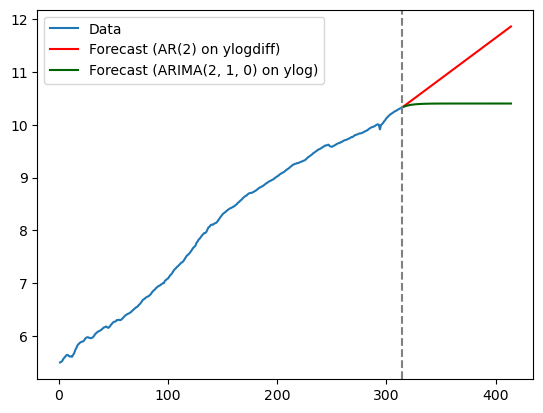

In [163]:
fcast_2 = ar2_nodiff.get_prediction(start = n, end = n+k-1).predicted_mean

plt.plot(tme, ylog, label = 'Data')
plt.plot(tme_future, fcast_1, label = 'Forecast (AR(2) on ylogdiff)', color = 'red')
plt.plot(tme_future, fcast_2, label = 'Forecast (ARIMA(2, 1, 0) on ylog)', color = 'darkgreen')
plt.axvline(x=n, color='gray', linestyle='--')
plt.legend()
plt.show()

The reason the predictions are different is because the ARIMA model does not fit a constant term when $d > 1$. To get the constant term with $d = 1$, one needs to use the trend = 't' option. 

In [167]:
ar2_nodiff_withintercept = ARIMA(ylog, order = (2, 1, 0), trend = 't').fit() #note the trend = 't'
print(ar2_nodiff_withintercept.summary())


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  314
Model:                 ARIMA(2, 1, 0)   Log Likelihood                 935.005
Date:                Tue, 18 Nov 2025   AIC                          -1862.010
Time:                        16:42:17   BIC                          -1847.025
Sample:                             0   HQIC                         -1856.022
                                - 314                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0154      0.001     10.725      0.000       0.013       0.018
ar.L1          0.1971      0.025      7.856      0.000       0.148       0.246
ar.L2          0.2077      0.066      3.140      0.0

In [165]:
print(ar2.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  313
Model:                 ARIMA(2, 0, 0)   Log Likelihood                 935.005
Date:                Tue, 18 Nov 2025   AIC                          -1862.010
Time:                        16:41:07   BIC                          -1847.025
Sample:                             0   HQIC                         -1856.022
                                - 313                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0154      0.001     10.725      0.000       0.013       0.018
ar.L1          0.1971      0.025      7.856      0.000       0.148       0.246
ar.L2          0.2077      0.066      3.140      0.0

Note that the summaries for AR(2) fitted to ylogdiff and ARIMA((2, 1, 0), trend = 'n') fitted to ylog are almost fully identical (one difference is in the number of observations; it is one smaller for AR(2)). 

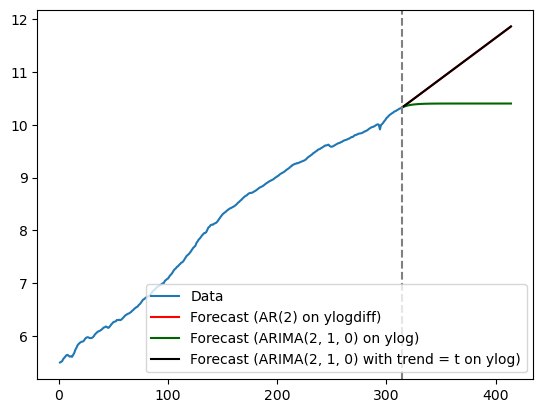

In [168]:
fcast_3 = ar2_nodiff_withintercept.get_prediction(start = n, end = n+k-1).predicted_mean

plt.plot(tme, ylog, label = 'Data')
plt.plot(tme_future, fcast_1, label = 'Forecast (AR(2) on ylogdiff)', color = 'red')
plt.plot(tme_future, fcast_2, label = 'Forecast (ARIMA(2, 1, 0) on ylog)', color = 'darkgreen')
plt.plot(tme_future, fcast_3, label = 'Forecast (ARIMA(2, 1, 0) with trend = t on ylog)', color = 'black')
plt.axvline(x=n, color='gray', linestyle='--')
plt.legend()
plt.show()

The predictions on ARIMA(2, 1, 0) with trend = t coincide with the predictions for $\log y_t$ obtained via AR(2) on $\log (y_t/y_{t-1})$. 

### Selecting the best ARIMA($p$, $d$, $q$) model by AIC or BIC

Below we go over all possible values of $p \leq 5$, $d \leq 2$ and $q \leq 5$ and calculate the AIC, BIC values of each ARIMA model. We use the default ARIMA (no modification for inclusion of intercepts when $d \geq 1$). 

In [169]:
import warnings
warnings.filterwarnings("ignore") #this suppresses convergence warnings. 

dt = ylog
pmax, dmax, qmax = 5, 2, 5

results = []

for p in range(pmax + 1):
    for d in range(dmax + 1):
        for q in range(qmax + 1):

            # Use linear trend only when d = 1
            #trend = 't' if d == 1 else None
            #trend = 'n'if d >= 1 else 'c'

            try:
                model = ARIMA(dt, order=(p, d, q)).fit()

                results.append({
                    'p': p, 'd': d, 'q': q,
                    'trend': trend,
                    'AIC': model.aic,
                    'BIC': model.bic
                })
            except Exception as e:
                print(f"ARIMA({p},{d},{q}, trend={trend}) failed: {e}")
                continue

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Find best models
best_aic_model = results_df.loc[results_df['AIC'].idxmin()]
best_bic_model = results_df.loc[results_df['BIC'].idxmin()]

print("Best model by AIC:")
print(best_aic_model)

print("\nBest model by BIC:")
print(best_bic_model)


Best model by AIC:
p                  1
d                  1
q                  3
trend              n
AIC     -1860.201397
BIC     -1841.470381
Name: 27, dtype: object

Best model by BIC:
p                  0
d                  2
q                  3
trend              n
AIC     -1856.667535
BIC     -1841.695523
Name: 15, dtype: object


The best ARIMA($p, d, q$) model (searched over $p \leq 5$, $d \leq 2$, $q \leq 5$) is ARIMA(1, 1, 3) (by AIC) and ARIMA(0, 2, 3) (by BIC). Note I used the default ARIMA functions with no modification for including intercepts in the models with $d \geq 1$. 

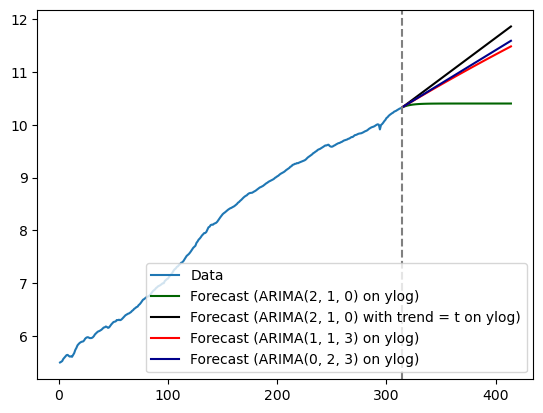

In [170]:
arima113 = ARIMA(ylog, order = (1, 1, 3)).fit()
fcast_4 = arima113.get_prediction(start = n, end = n+k-1).predicted_mean

arima023 = ARIMA(ylog, order = (0, 2, 3)).fit()
fcast_5 = arima023.get_prediction(start = n, end = n+k-1).predicted_mean

plt.plot(tme, ylog, label = 'Data')
plt.plot(tme_future, fcast_2, label = 'Forecast (ARIMA(2, 1, 0) on ylog)', color = 'darkgreen')
plt.plot(tme_future, fcast_3, label = 'Forecast (ARIMA(2, 1, 0) with trend = t on ylog)', color = 'black')
plt.plot(tme_future, fcast_4, label = 'Forecast (ARIMA(1, 1, 3) on ylog)', color = 'red')
plt.plot(tme_future, fcast_5, label = 'Forecast (ARIMA(0, 2, 3) on ylog)', color = 'darkblue')
plt.axvline(x=n, color='gray', linestyle='--')
plt.legend()
plt.show()

Here are the predictions on the original data. 

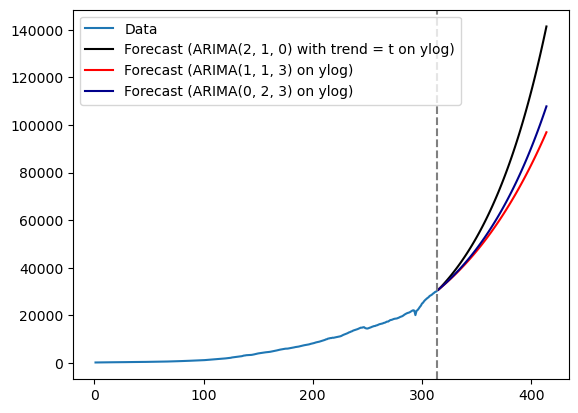

In [171]:
plt.plot(tme, y, label = 'Data')
plt.plot(tme_future, np.exp(fcast_3), label = 'Forecast (ARIMA(2, 1, 0) with trend = t on ylog)', color = 'black')
plt.plot(tme_future, np.exp(fcast_4), label = 'Forecast (ARIMA(1, 1, 3) on ylog)', color = 'red')
plt.plot(tme_future, np.exp(fcast_5), label = 'Forecast (ARIMA(0, 2, 3) on ylog)', color = 'darkblue')
plt.axvline(x=n, color='gray', linestyle='--')
plt.legend()
plt.show()

We can compare the AIC and BIC of the best models above (ARIMA(1, 1, 3) and ARIMA(0, 2, 3)) with ARIMA(2, 1, 0) with trend = t

In [172]:
print(ar2_nodiff_withintercept.aic, ar2_nodiff_withintercept.bic)
print(arima113.aic, arima113.bic)
print(arima023.aic, arima023.bic)

-1862.0098207563674 -1847.0250079942068
-1860.2013971103497 -1841.470381157649
-1856.6675352600519 -1841.6955225088138


This suggests that the AR(2) with intercept is better than these models ARIMA(1, 1, 3) and ARIMA(0, 2, 3) without intercepts. 

Note that the predictions look different but this is because we are looking at long range forecasts ($k = 100$ corresponds to 25 future years!) If we look at short range forecasts (such as $k = 12$), then the predictions will be quite close to each other. 

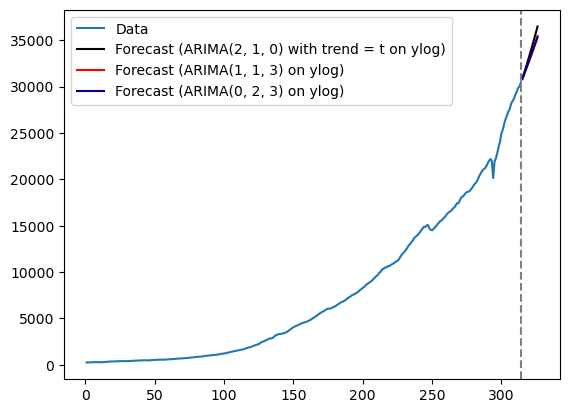

In [173]:
plt.plot(tme, y, label = 'Data')
#below we only plot the first 8 predictions
k_short = 12
plt.plot(tme_future[0:k_short], np.exp(fcast_3)[0:k_short], label = 'Forecast (ARIMA(2, 1, 0) with trend = t on ylog)', color = 'black')
plt.plot(tme_future[0:k_short], np.exp(fcast_4)[0:k_short], label = 'Forecast (ARIMA(1, 1, 3) on ylog)', color = 'red')
plt.plot(tme_future[0:k_short], np.exp(fcast_5)[0:k_short], label = 'Forecast (ARIMA(0, 2, 3) on ylog)', color = 'darkblue')
plt.axvline(x=n, color='gray', linestyle='--')
plt.legend()
plt.show()

## TTLCONS Dataset

    observation_date  TTLCONS
386       2025-03-01  2150847
387       2025-04-01  2153440
388       2025-05-01  2149124
389       2025-06-01  2140546
390       2025-07-01  2139110
391


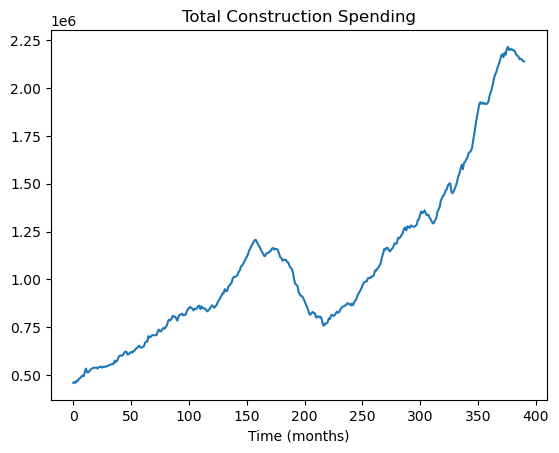

In [4]:
ttlcons = pd.read_csv('TTLCONS_13Nov2025.csv')
print(ttlcons.tail())
y = ttlcons['TTLCONS'].to_numpy()
print(len(y))
plt.plot(y)
plt.title('Total Construction Spending')
plt.xlabel('Time (months)')
plt.show()

We fit models to the logarithm of the data. 

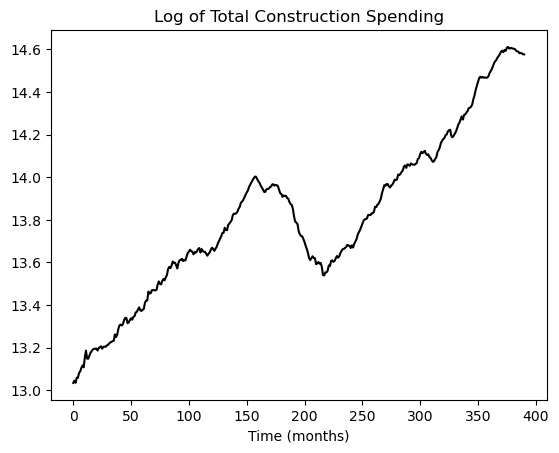

In [5]:
ylog = np.log(y)
plt.plot(ylog, color = 'black')
plt.title('Log of Total Construction Spending')
plt.xlabel('Time (months)')
plt.show()  

We can obtain candidate models by differencing the data, and looking at acf and pacf. 

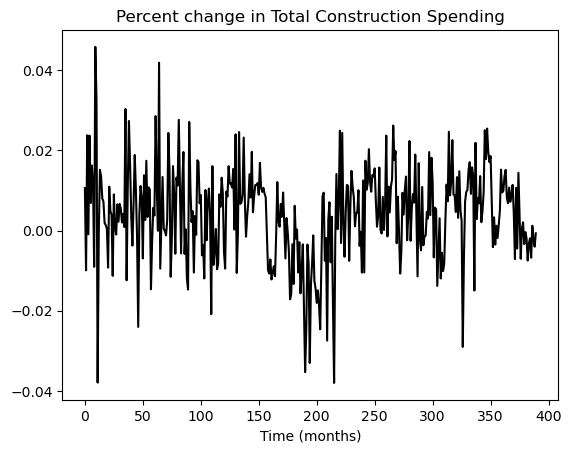

In [6]:
ylogdiff = np.diff(ylog)
plt.plot(ylogdiff, color = 'black')
plt.title('Percent change in Total Construction Spending')
plt.xlabel('Time (months)')
plt.show()

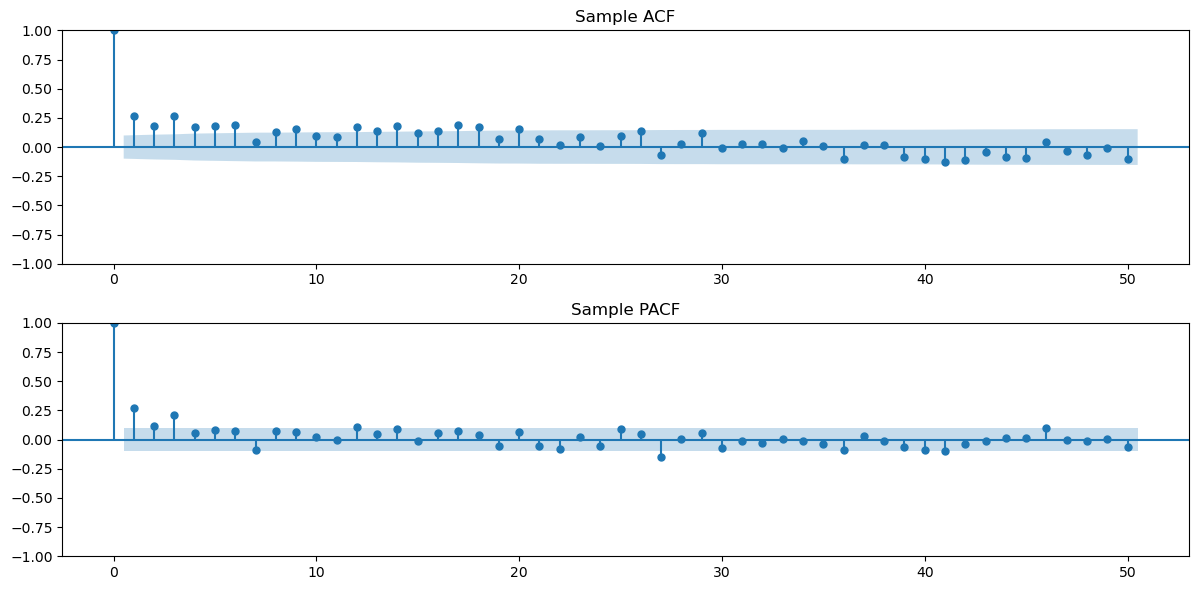

In [7]:
h_max = 50
fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (12, 6))
plot_acf(ylogdiff, lags = h_max, ax = axes[0])
axes[0].set_title("Sample ACF")
plot_pacf(ylogdiff, lags = h_max, ax = axes[1])
axes[1].set_title("Sample PACF")
plt.tight_layout()
plt.show()

From the above ACF and PACF plots, probably the best model for ylogdiff is AR(3). 

Let us go over all possible $p$ and $q$ and find the best model for ylogdiff. 

In [9]:
import warnings
warnings.filterwarnings("ignore") #this suppresses convergence warnings. 

dt = ylogdiff #arma fitting can be unstable. Change dt = ylogdiff to dt = 100*ylogdiff and check if results change
pmax = 5
qmax = 5

aicmat = np.full((pmax + 1, qmax + 1), np.nan)
bicmat = np.full((pmax + 1, qmax + 1), np.nan)

for i in range(pmax + 1):
    for j in range(qmax + 1):
        try:
            model = ARIMA(dt, order=(i, 0, j)).fit()
            aicmat[i, j] = model.aic
            bicmat[i, j] = model.bic
        except Exception as e:
            # Some models may not converge; skip them
            print(f"ARIMA({i},0,{j}) failed: {e}")
            continue

aic_df = pd.DataFrame(aicmat, index=[f'AR({i})' for i in range(pmax+1)],
                               columns=[f'MA({j})' for j in range(qmax+1)])
bic_df = pd.DataFrame(bicmat, index=[f'AR({i})' for i in range(pmax+1)],
                               columns=[f'MA({j})' for j in range(qmax+1)])

# Best AR model (MA = 0)
best_ar_aic = np.nanargmin(aicmat[:, 0])
best_ar_bic = np.nanargmin(bicmat[:, 0])

# Best MA model (AR = 0)
best_ma_aic = np.nanargmin(aicmat[0, :])
best_ma_bic = np.nanargmin(bicmat[0, :])

# Best ARMA model overall
best_arma_aic = np.unravel_index(np.nanargmin(aicmat), aicmat.shape)
best_arma_bic = np.unravel_index(np.nanargmin(bicmat), bicmat.shape)

# Print results
print(f"Best AR model by AIC: AR({best_ar_aic})")
print(f"Best AR model by BIC: AR({best_ar_bic})")

print(f"Best MA model by AIC: MA({best_ma_aic})")
print(f"Best MA model by BIC: MA({best_ma_bic})")

print(f"Best ARMA model by AIC: ARMA{best_arma_aic}")
print(f"Best ARMA model by BIC: ARMA{best_arma_bic}")


Best AR model by AIC: AR(5)
Best AR model by BIC: AR(3)
Best MA model by AIC: MA(5)
Best MA model by BIC: MA(3)
Best ARMA model by AIC: ARMA(1, 1)
Best ARMA model by BIC: ARMA(1, 1)


Best AR model: AR(3) (using BIC) and AR(5) (using AIC)

Best MA model: MA(3) (using BIC) and MA(5) (using AIC)

Best overall ARMA model: ARMA(1, 1)

Instead of fitting the best model to ylogdiff, we can find best models for ylog (in this case, we shall use ARIMA(p, d, q) and vary p, d, q). 

In [10]:
import warnings
warnings.filterwarnings("ignore") #this suppresses convergence warnings. 


dt = ylog
pmax, dmax, qmax = 5, 2, 5

results = []

for p in range(pmax + 1):
    for d in range(dmax + 1):
        for q in range(qmax + 1):

            # Use linear trend only when d = 1
            #trend = 't' if d == 1 else None
            #trend = None

            try:
                model = ARIMA(dt, order=(p, d, q)).fit()

                results.append({
                    'p': p, 'd': d, 'q': q,
                    'AIC': model.aic,
                    'BIC': model.bic
                })
            except Exception as e:
                print(f"ARIMA({p},{d},{q}) failed: {e}")
                continue

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Find best models
best_aic_model = results_df.loc[results_df['AIC'].idxmin()]
best_bic_model = results_df.loc[results_df['BIC'].idxmin()]

print("Best model by AIC:")
print(best_aic_model)

print("\nBest model by BIC:")
print(best_bic_model)


Best model by AIC:
p         1.000000
d         1.000000
q         1.000000
AIC   -2405.521236
BIC   -2393.622796
Name: 25, dtype: float64

Best model by BIC:
p         1.000000
d         1.000000
q         1.000000
AIC   -2405.521236
BIC   -2393.622796
Name: 25, dtype: float64


Best model is ARIMA(1, 1, 1). Let us use it for prediction. 

In [11]:
n = len(ylog)
k = 100
tme = range(1, n+1)
tme_future = range(n+1, n+k+1)

In [12]:
#ARIMA(1, 1, 1) model for ylog:
arima111 = ARIMA(ylog, order = (1, 1, 1)).fit()
print(arima111.summary())
fcast_arima111 = arima111.get_prediction(start = n, end = n+k-1).predicted_mean

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  391
Model:                 ARIMA(1, 1, 1)   Log Likelihood                1205.761
Date:                Tue, 18 Nov 2025   AIC                          -2405.521
Time:                        20:58:32   BIC                          -2393.623
Sample:                             0   HQIC                         -2400.805
                                - 391                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9682      0.018     54.374      0.000       0.933       1.003
ma.L1         -0.8394      0.040    -21.130      0.000      -0.917      -0.762
sigma2         0.0001   6.69e-06     17.962      0.0

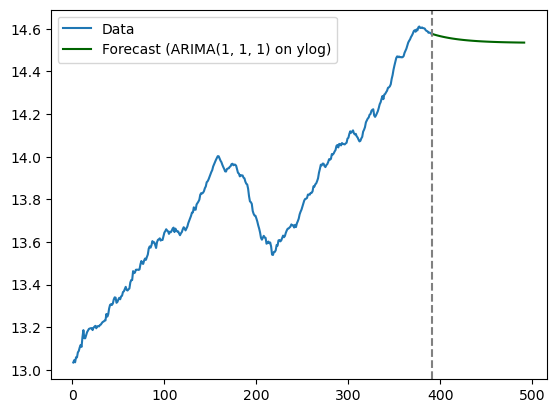

In [13]:
plt.plot(tme, ylog, label = 'Data')
plt.plot(tme_future, fcast_arima111, label = 'Forecast (ARIMA(1, 1, 1) on ylog)', color = 'darkgreen')
plt.axvline(x=n, color='gray', linestyle='--')
plt.legend()
plt.show()

If we include the intercept term in ARIMA(1, 1, 1), then the predictions will be different. 

In [14]:
arima111_t = ARIMA(ylog, order = (1, 1, 1), trend = 't').fit() #trend = 't' includes the intercept term
fcast_arima111_t = arima111_t.get_prediction(start = n, end = n+k-1).predicted_mean


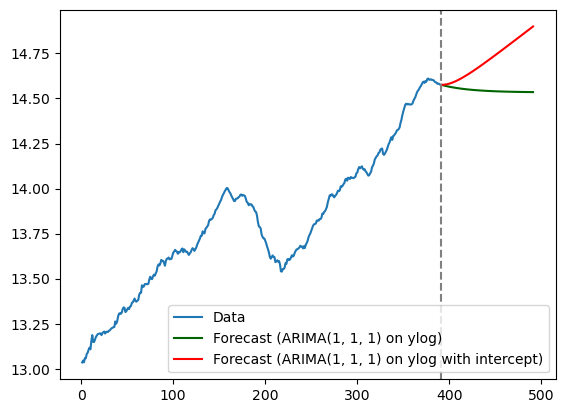

In [15]:
plt.plot(tme, ylog, label = 'Data')
plt.plot(tme_future, fcast_arima111, label = 'Forecast (ARIMA(1, 1, 1) on ylog)', color = 'darkgreen')
plt.plot(tme_future, fcast_arima111_t, label = 'Forecast (ARIMA(1, 1, 1) on ylog with intercept)', color = 'red')
plt.axvline(x=n, color='gray', linestyle='--')
plt.legend()
plt.show()

Which of these predictions would we prefer? We can compare the AIC and BIC of the model with and without the intercept.

In [186]:
print(arima111.aic, arima111.bic)
print(arima111_t.aic, arima111_t.bic)


-2405.524371156208 -2393.625930938837
-2406.8821088764494 -2391.0175219199546


It is interesting that in terms of the AIC, the model with intercept is better, while in terms of BIC, the model without intercept is better. The predictions for the model with no intercept look more natural. 

## Other Models for TTLCONS

Below we consider the double differenced dataset. 

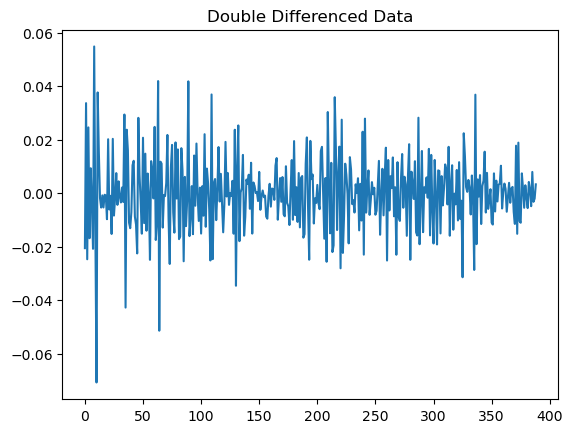

In [16]:
ylogdiff2 = np.diff(np.diff(ylog))
plt.plot(ylogdiff2)
plt.title("Double Differenced Data")
plt.show()

Let us attempt to find best ARMA($p$, $q$) models for this data. 

In [17]:
dt = 100*ylogdiff2 #notice the multiplication by 100 (without it the code does not seem to work well)
pmax = 5
qmax = 5

aicmat = np.full((pmax + 1, qmax + 1), np.nan)
bicmat = np.full((pmax + 1, qmax + 1), np.nan)

for i in range(pmax + 1):
    for j in range(qmax + 1):
        try:
            model = ARIMA(dt, order=(i, 0, j)).fit()
            aicmat[i, j] = model.aic
            bicmat[i, j] = model.bic
        except Exception as e:
            # Some models may not converge; skip them
            print(f"ARIMA({i},0,{j}) failed: {e}")
            continue

aic_df = pd.DataFrame(aicmat, index=[f'AR({i})' for i in range(pmax+1)],
                               columns=[f'MA({j})' for j in range(qmax+1)])
bic_df = pd.DataFrame(bicmat, index=[f'AR({i})' for i in range(pmax+1)],
                               columns=[f'MA({j})' for j in range(qmax+1)])

# Best AR model (MA = 0)
best_ar_aic = np.nanargmin(aicmat[:, 0])
best_ar_bic = np.nanargmin(bicmat[:, 0])

# Best MA model (AR = 0)
best_ma_aic = np.nanargmin(aicmat[0, :])
best_ma_bic = np.nanargmin(bicmat[0, :])

# Best ARMA model overall
best_arma_aic = np.unravel_index(np.nanargmin(aicmat), aicmat.shape)
best_arma_bic = np.unravel_index(np.nanargmin(bicmat), bicmat.shape)

# Print results
print(f"Best AR model by AIC: AR({best_ar_aic})")
print(f"Best AR model by BIC: AR({best_ar_bic})")

print(f"Best MA model by AIC: MA({best_ma_aic})")
print(f"Best MA model by BIC: MA({best_ma_bic})")

print(f"Best ARMA model by AIC: ARMA{best_arma_aic}")
print(f"Best ARMA model by BIC: ARMA{best_arma_bic}")


Best AR model by AIC: AR(5)
Best AR model by BIC: AR(5)
Best MA model by AIC: MA(4)
Best MA model by BIC: MA(1)
Best ARMA model by AIC: ARMA(2, 4)
Best ARMA model by BIC: ARMA(0, 1)


According to BIC, the best model is MA(1). This is the same model that is suggested by ACF and PACF. 

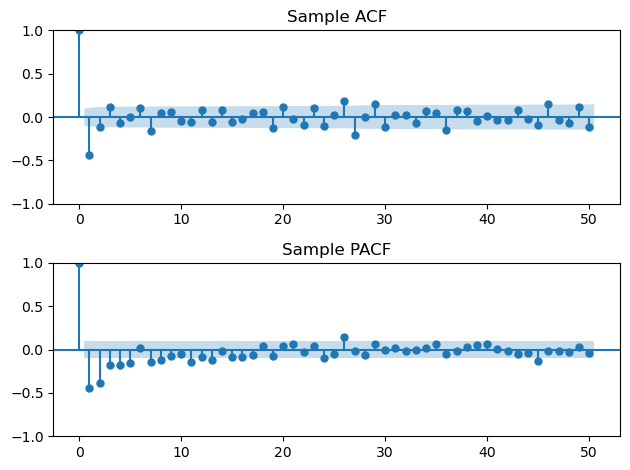

In [189]:
h_max = 50
fig, axes = plt.subplots(nrows = 2, ncols = 1)
plot_acf(ylogdiff2, lags = h_max, ax = axes[0])
axes[0].set_title("Sample ACF")
plot_pacf(ylogdiff2, lags = h_max, ax = axes[1])
axes[1].set_title("Sample PACF")
plt.tight_layout()
plt.show()

This suggests the ARIMA(0, 2, 1) model for ylog. 

In [18]:
arima021 = ARIMA(ylog, order = (0, 2, 1)).fit()
print(arima021.summary())
fcast_arima021 = arima021.get_prediction(start = n, end = n+k-1).predicted_mean

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  391
Model:                 ARIMA(0, 2, 1)   Log Likelihood                1199.732
Date:                Tue, 18 Nov 2025   AIC                          -2395.464
Time:                        21:03:58   BIC                          -2387.537
Sample:                             0   HQIC                         -2392.321
                                - 391                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8732      0.026    -33.741      0.000      -0.924      -0.823
sigma2         0.0001   6.74e-06     18.122      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   1.69   Jarque-

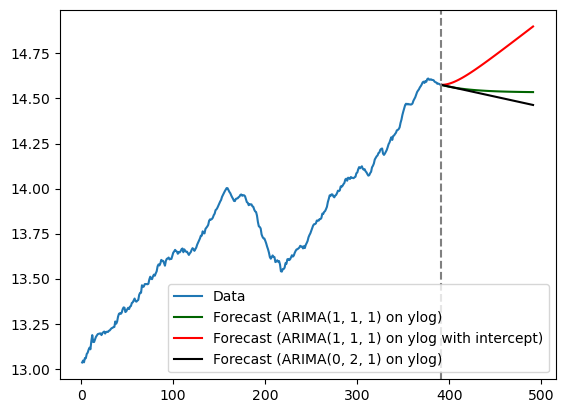

In [19]:
plt.plot(tme, ylog, label = 'Data')
plt.plot(tme_future, fcast_arima111, label = 'Forecast (ARIMA(1, 1, 1) on ylog)', color = 'darkgreen')
plt.plot(tme_future, fcast_arima111_t, label = 'Forecast (ARIMA(1, 1, 1) on ylog with intercept)', color = 'red')
plt.plot(tme_future, fcast_arima021, label = 'Forecast (ARIMA(0, 2, 1) on ylog)', color = 'black')
plt.axvline(x=n, color='gray', linestyle='--')
plt.legend()
plt.show()

The model ARIMA(0, 2, 1) does not include any intercept term. We can also fit MA(1) to ylogdiff2, and then convert the predictions for the double differenced data to ylog. 

In [24]:
#predictions for ylogdiff2: 
ma1_diff2 = ARIMA(ylogdiff2, order = (0, 0, 1)).fit()
fcast_diff2 = (ma1_diff2.get_prediction(start = n-2, end = n+k-3).predicted_mean)/100 #the division by 100 is because ylogdiff2 has a multiplication by 100 in its definition

The code below converts predictions for diff(diff(ylog)) into predictions for ylog. 

In [25]:
tmp1 = ylog[-1] - ylog[-2]
fcast_d1 = np.zeros(k)
fcast_d1[0] = tmp1 + fcast_diff2[0]
for i in range(1, k):
    fcast_d1[i] = fcast_d1[i-1] + fcast_diff2[i]
tmp2 = ylog[-1]
fcast_ma1_diff2 = np.zeros(k)
fcast_ma1_diff2[0] = tmp2 + fcast_d1[0]
for i in range(1, k):
    fcast_ma1_diff2[i] = fcast_ma1_diff2[i-1] + fcast_d1[i]

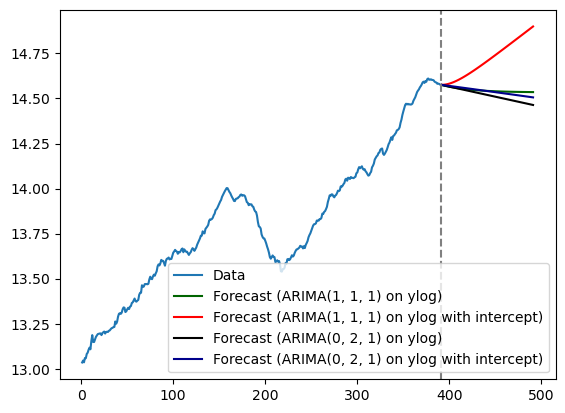

In [26]:
plt.plot(tme, ylog, label = 'Data')
plt.plot(tme_future, fcast_arima111, label = 'Forecast (ARIMA(1, 1, 1) on ylog)', color = 'darkgreen')
plt.plot(tme_future, fcast_arima111_t, label = 'Forecast (ARIMA(1, 1, 1) on ylog with intercept)', color = 'red')
plt.plot(tme_future, fcast_arima021, label = 'Forecast (ARIMA(0, 2, 1) on ylog)', color = 'black')
plt.plot(tme_future, fcast_ma1_diff2, label = 'Forecast (ARIMA(0, 2, 1) on ylog with intercept)', color = 'darkblue')
plt.axvline(x=n, color='gray', linestyle='--')
plt.legend()
plt.show()

These predictions (except for the red predictions) seem divergent because the horizon of prediction is very long. If we do short range predictions, they are much closer. 

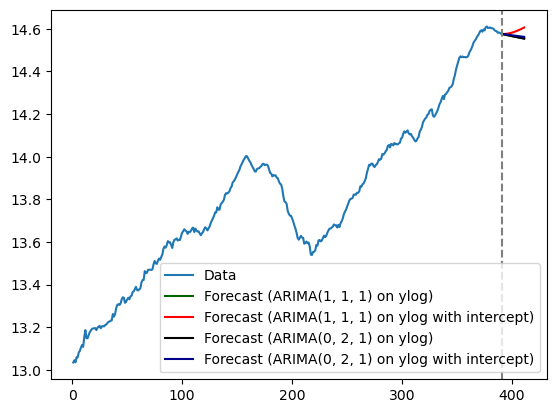

In [27]:
k_short = 20
plt.plot(tme, ylog, label = 'Data')
plt.plot(tme_future[0:k_short], fcast_arima111[0:k_short], label = 'Forecast (ARIMA(1, 1, 1) on ylog)', color = 'darkgreen')
plt.plot(tme_future[0:k_short], fcast_arima111_t[0:k_short], label = 'Forecast (ARIMA(1, 1, 1) on ylog with intercept)', color = 'red')
plt.plot(tme_future[0:k_short], fcast_arima021[0:k_short], label = 'Forecast (ARIMA(0, 2, 1) on ylog)', color = 'black')
plt.plot(tme_future[0:k_short], fcast_ma1_diff2[0:k_short], label = 'Forecast (ARIMA(0, 2, 1) on ylog with intercept)', color = 'darkblue')
plt.axvline(x=n, color='gray', linestyle='--')
plt.legend()
plt.show()